<ErrorbarContainer object of 3 artists>

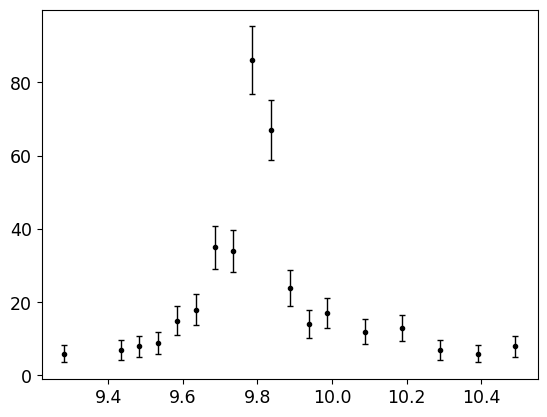

In [48]:
from os import listdir
from os.path import join
from numpy import *
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
matplotlib.rcParams.update({'font.size': 12.5})


# Load my modules.
import sys
with open("modules.txt") as file:
    for line in file:
        path = line.rstrip()
        sys.path.append(path)
from CommonUtilities import *

# Load experiment data, drop blank columns, and filter outliers.
experiments = pd.read_csv("pendulumData.csv")
g_I = experiments["g (m/s2)"].to_numpy()
g_I = g_I[~isnan(g_I)]
g_I = g_I[g_I < 100]
N = len(g_I)
mu, sigma = mean(g_I), std(g_I, ddof=1)
sigma_mu = sigma / sqrt(N)

# Calculate histogram.
N_bins = 300
counts, edges = histogram(g_I, N_bins)
width = edges[1] - edges[0]
centers = (edges[:-1] + edges[1:]) / 2
scale = N * width

# Eliminate histogram bins with too few counts or too far from mean.
keep = where((counts > 5) * (abs(centers - mu) / sigma < 3))
counts, centers = counts[keep], centers[keep]
plt.errorbar(centers, counts, yerr=sqrt(counts), fmt='o', c="k", markersize=3, capsize=2, elinewidth=1, zorder=10,
             label="Exp. Data")

123.12665640638618
[9.85721077 0.3271465 ]
[0.05307073 0.05468313]


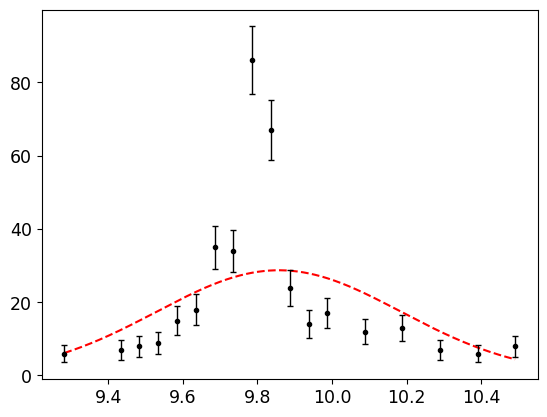

In [52]:
"""
Single Gaussian.
"""

# Simplest: one peak model.
def model1(g: float, mu: float, sigma: float):
    prefactor = 1 / sqrt(2 * pi * sigma ** 2)
    argument = - (g - mu) ** 2 / (2 * sigma ** 2)
    return(prefactor * exp(argument))

# Calculate fit and statistics.
args, covs = curve_fit(model1, xdata=centers, ydata=counts / scale,
                       sigma=sqrt(counts) / scale,
                       p0 = [mu, sigma_mu])
stds = sqrt(diag(covs))
chi2 = calc_chi2(model1, args, centers, counts / scale, sqrt(counts) / scale)
print(chi2)
print(args)
print(stds)

grid = linspace(amin(centers), amax(centers), 1000)
plt.errorbar(centers, counts, yerr=sqrt(counts), fmt='o', c="k", markersize=3, capsize=2, elinewidth=1, zorder=10,
             label="Exp. Data")
plt.plot(grid, scale * model1(grid, *args),
         linestyle="--", color="r", label=f"Gaussian Fit\n$\\mu$={mu:.3f}±{sigma_mu:.3f}\n$\\sigma$={sigma:.2f}")

[0.32030284 9.80021859 0.04126343 9.86273384 0.37890911]
[0.03825576 0.00523201 0.0050728  0.04070661 0.04584661]


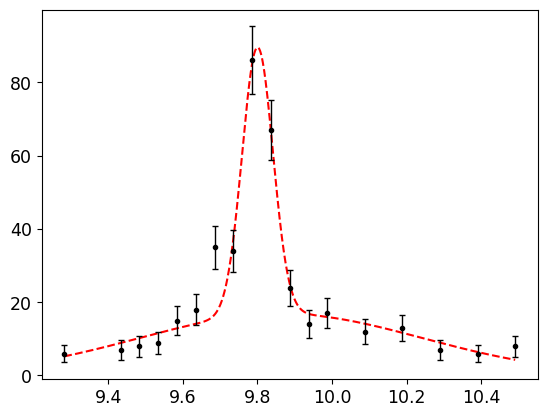

In [46]:
def model2(g: float, alpha: float, mu_1: float, sigma_1: float, mu_2: float, sigma_2: float):
    prefactor_1 = 1 / sqrt(2 * pi * sigma_1 ** 2)
    argument_1 = - (g - mu_1) ** 2 / (2 * sigma_1 ** 2)
    prefactor_2 = 1 / sqrt(2 * pi * sigma_2 ** 2)
    argument_2 = - (g - mu_2) ** 2 / (2 * sigma_2 ** 2)
    two_peak = alpha * prefactor_1 * exp(argument_1) + (1 - alpha) * prefactor_2 * exp(argument_2)
    return two_peak

args, covs = curve_fit(model2, xdata=centers, ydata=counts / scale,
                       sigma=sqrt(counts) / scale,
                       p0 = [0.5, mu, 0.5 * sigma_mu, mu, 2 * sigma_mu])
stds = sqrt(diag(covs))
print(args)
print(stds)

grid = linspace(amin(centers), amax(centers), 1000)
plt.errorbar(centers, counts, yerr=sqrt(counts), fmt='o', c="k", markersize=3, capsize=2, elinewidth=1, zorder=10,
             label="Exp. Data")
plt.plot(grid, scale * model2(grid, *args),
         linestyle="--", color="r", label=f"Gaussian Fit\n$\\mu$={mu:.3f}±{sigma_mu:.3f}\n$\\sigma$={sigma:.2f}")